# I. INTRODUCTION

Sebagai Data Scientist di bank, peran utama saya adalah mengembangkan model prediktif untuk menilai kemungkinan nasabah baru akan mengalami gagal bayar bulan depan. Prioritasnya adalah meminimalkan kesalahan prediksi di mana nasabah yang diperkirakan tidak gagal bayar ternyata gagal bayar.

Selain itu, akan dilakukan analisis mendalam terhadap data yang ada untuk mengidentifikasi wawasan baru yang bisa diterapkan dalam strategi bisnis ke depan.

# II. PROBLEM STATEMENT/OBJECTIVE


Tujuan dari project ini adalah menentukan model yang terbaik dan membuat machine learning untuk memprediksi pengguna kartu kredit berpotensi mengalami gagal bayar atau tidak.

# III. SQL QUERY

In [1]:
# Connecting Google collab with BigQuery

from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
print('Authenticated')

project_id = "boxwood-ellipse-403804"
client = bigquery.Client(project=project_id)

Authenticated


In [2]:
# Import dataset form BigQuery

query = '''
SELECT
    limit_balance,
    CAST(sex AS INT64) AS sex,
    CAST(education_level AS INT64) AS education_level,
    CAST(marital_status AS INT64) AS marital_status,
    age,
    pay_0,
    pay_2,
    pay_3,
    pay_4,
    CAST(pay_5 AS FLOAT64) AS pay_5,
    CAST(pay_6 AS FLOAT64) AS pay_6,
    bill_amt_1,
    bill_amt_2,
    bill_amt_3,
    bill_amt_4,
    bill_amt_5,
    bill_amt_6,
    pay_amt_1,
    pay_amt_2,
    pay_amt_3,
    pay_amt_4,
    pay_amt_5,
    pay_amt_6,
    CAST(default_payment_next_month AS INT64) AS default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 9985;
'''

In [3]:
# Read dataset
df = client.query(query).to_dataframe()

In [4]:
# Save dataset to .csv
df.to_csv('credit_card.csv', index=False)

# IV. IMPORT LIBRARIES

In [5]:
# For Exploratory Data Analysis (EDA)
import pandas as pd
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Algorithm -> Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder

# For Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score

# For Model Inference
import pickle
import json

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Show all columns
pd.set_option('display.max_columns', None)

# For Google Colab integration (if working in Google Colab)
from google.colab import drive  # To access Google Drive in Colab

# V. LOAD DATASET

## 5.1 From Google Drive

In [6]:
# Force remount to refresh authentication
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# Read the dataset from drive
df = pd.read_csv('/content/drive/MyDrive/Project (Portofolio)/Credit Card/credit_card.csv')  # Read the file after mounting

# Adjust Pandas settings to display all columns in the output
pd.set_option('display.max_columns', None)

# Display the first 5 rows of the DataFrame:
df.head()  # Show the first 5 rows to get an overview of the data

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


# VI. DATA OVERVIEW

|**Column**|**Expalination**|
|:-----:|:----------|
|`limit_balance`|Amount of given credit treasury limit in NT dollars, includes individual and family/supplementary credit|
|`sex`|Gender (1=male & 2=female)|
|`education_level`|Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)|
|`marital_status`|Marital status (1=married, 2=single, 3=divore, 0=others)|
|`age`|Age in years|
|`pay_0`|Repayment status in September, 2005 (-1=pay duly, 0=payment in time, 1=payment delay for one month, 2=payment delay for two months, and so on)
|`pay_2`|Repayment status in August, 2005 (scale same as above)|
|`pay_3`|Repayment status in July, 2005 (scale same as above)|
|`pay_4`|Repayment status in June, 2005 (scale same as above)|
|`pay_5`|Repayment status in May, 2005 (scale same as above)|
|`pay_6`|Repayment status in April, 2005 (scale same as above)|
|`bill_amt_1`|Amount of bill statement in September, 2005 (NT dollar)|
|`bill_amt_2`|Amount of bill statement in August, 2005 (NT dollar)|
|`bill_amt_3`|Amount of bill statement in July, 2005 (NT dollar)|
|`bill_amt_4`|Amount of bill statement in June, 2005 (NT dollar)|
|`bill_amt_5`|Amount of bill statement in May, 2005 (NT dollar)|
|`bill_amt_6`|Amount of bill statement in April, 2005 (NT dollar)|
|`pay_amt_1`|Amount of previous payment in September, 2005 (NT dollar)|
|`pay_amt_2`|Amount of previous payment in August, 2005 (NT dollar)|
|`pay_amt_3`|Amount of previous payment in July, 2005 (NT dollar)|
|`pay_amt_4`|Amount of previous payment in June, 2005 (NT dollar)|
|`pay_amt_5`|Amount of previous payment in May, 2005 (NT dollar)|
|`pay_amt_6`|Amount of previous payment in April, 2005 (NT dollar)|
|`default_payment_next_month`|Default payment (1=yes, 0=no)|

In [8]:
# Dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

- Dataset memiliki 2965 data dan 23 kolom, juga tipe data sudah sesuai. Dataset juga semua bernilai numerikal.

In [9]:
# Missing value check
df.isna().sum()

,0
limit_balance,0
sex,0
education_level,0
marital_status,0
age,0
pay_0,0
pay_2,0
pay_3,0
pay_4,0
pay_5,0


- Tidak terdapat missing value pada dataset

In [10]:
# Statistic desriptive
df.describe()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,163369.308600,1.607757,1.849578,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,-0.225295,-0.254637,52118.305228,50649.153120,48239.757504,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
std,125030.415472,0.488333,0.778184,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,1.159003,1.167305,72328.670541,70785.001588,68145.710745,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-11545.000000,-67526.000000,-25443.000000,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3958.000000,3390.000000,3302.000000,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24257.000000,23111.000000,21520.000000,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
75%,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69852.000000,67827.000000,63023.000000,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000,0.000000
max,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,7.000000,7.000000,613860.000000,512650.000000,578971.000000,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


- Ringkasan statistik deskriptif dari dataset, kita bisa melihat informasi singkat dari dataset seperti, umur rata-rata dari penggunga kartu kredit adalah 34 Tahun.

## 6.1 Duplicate Data

In [11]:
# Duplicate Check
df.duplicated()

print('Jumlah duplikat dalam Dataset:', df.duplicated().sum())

Jumlah duplikat dalam Dataset: 1


- Terdapat 1 data yang duplikat, oleh karena itu harus dilakukan drop (hapus) duplikat

In [12]:
# Count number of duplicate rows (across all columns)
duplicate_rows = df.duplicated().sum()

# Count the total number of rows in the dataframe
total_rows = df.shape[0]

# Calculate the percentage of duplicate rows from the total number of rows
percentage_duplicates = (duplicate_rows / total_rows) * 100

# Display the duplicate percentage result with 2 decimal places
print(f"Persentasi banyak duplikat dalam data: {percentage_duplicates:.2f}%")

Persentasi banyak duplikat dalam data: 0.03%


In [13]:
# View the rows in the dataframe df that are duplicates
df[df.duplicated(keep=False)]

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2806,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2815,200000.0,2,1,1,34.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:
# Drop duplicate rows
df = df.drop_duplicates()

# Verify if duplicates have been removed
print('Jumlah duplikat dalam Dataset setelah dihapus:', df.duplicated().sum())


Jumlah duplikat dalam Dataset setelah dihapus: 0


## 6.2 Column(s) Handling


### 6.2.1 Rename Column(s)

In [15]:
# Renaming the column 'default_payment_next_month' to 'default_payment' and 'pay_0' to 'pay_1' in the DataFrame df
df.rename(columns={'default_payment_next_month':'default_payment', 'pay_0':'pay_1'}, inplace=True)

# Displaying the first five rows of the DataFrame df after the column name changes
df.head()

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment
0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0


### 6.2.2 Handling Cardinality

#### 6.2.2.1 Handling Cardinality `education_level`

In [16]:
# Calculating the count of each unique value in the 'education_level' column of the DataFrame df
df['education_level'].value_counts()

,count
education_level,
2,1400
1,1038
3,483
5,24
4,13
6,4
0,2


- Terdapat nilai yang harus disesuaikan: 5 & 6 (Unknown) dimasukan kedalam 4 (Others) dan 0 (Null) dimasukan kedalam 4 (Others)

In [17]:
# Replacing values in the 'education_level' column with new values based on the specified replacements
df['education_level'] = df['education_level'].replace({5: 4, 6: 4, 0: 4})

# Calculating the count of each unique value in the 'education_level' column of the DataFrame df after value replacement
df['education_level'].value_counts()

,count
education_level,
2,1400
1,1038
3,483
4,43


- Nilai `education_level` telah berhasil disesuaikan

#### 6.2.2.2 Handling Cardinality `marital_status`

In [18]:
# Calculating the count of each unique value in the 'marital_status' column of the DataFrame df
df['marital_status'].value_counts()

,count
marital_status,
2,1594
1,1331
3,35
0,4


- Terdapat nilai 0 yang akan digabung ke nilai 3 (dimasukan dalam nilai 'divorce') agar memudahkan dalam pengelompokan dan mengurangi kardinalitas

In [19]:
# Replacing values in the 'marital_status' column with new values based on the specified replacement
df['marital_status'] = df['marital_status'].replace({0: 3})

# Calculating the count of each unique value in the 'marital_status' column of the DataFrame df after value replacement
df['marital_status'].value_counts()

,count
marital_status,
2,1594
1,1331
3,39


### 6.2.3 Column(s) Manipulation

Agar analisa dan visualisasi lebih mudah, akan dilakukan manipulasi pada kolom `default_payment`

In [20]:
# Changing values 1 to 'True' and 0 to 'False'
df['default_payment'] = df['default_payment'].replace({1: True, 0: False})

## 6.3 Copy DataFrame for EDA

In [21]:
# Creating a copy of the DataFrame df to df_eda
df_eda = df.copy()

# Displaying the first five rows of the DataFrame df_eda
df_eda.head()

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment
0,80000.0,1,4,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,True
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,False
2,20000.0,2,4,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,True
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,False
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,False


# VII. EXPLORATORY DATA ANALYSIS

Seperti yang dijelaskan sebelumnya, bahwa tujuan analisis ini adalah untuk memprediksi kemungkinan nasabah kartu kredit akan gagal bayar atau tidak. Maka, kolom `default_payment` akan dijadikan sebagai kolom target

keterangan:
- 0   = Tidak gagal bayar
- 1   = Gagal bayar

## 7.1 Distribution of  Default Payment

### 7.1.1 Distribution of Default Payment by Gender


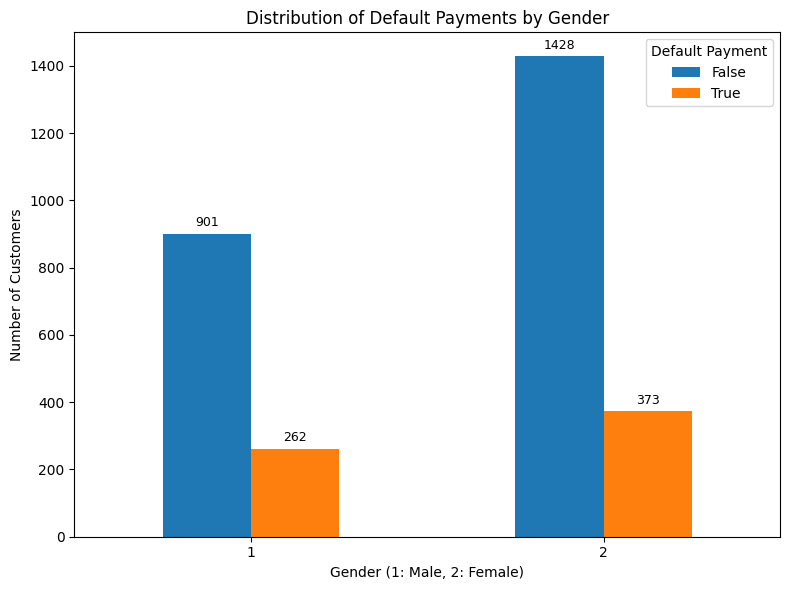

In [22]:
# Calculate the number of defaults per gender
default_by_gender = df_eda.groupby('sex')['default_payment'].value_counts().unstack()

# Plot the number of defaults
ax = default_by_gender.plot(kind='bar', figsize=(8, 6))

plt.title('Distribution of Default Payments by Gender')
plt.xlabel('Gender (1: Male, 2: Female)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.legend(title='Default Payment', labels=['False', 'True'])
plt.tight_layout()

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

plt.show()

- Nasabah dengan jenis kelamin perempuan lebih banyak dibandingkan dengan laki-laki

- Nasabah perempuan juga lebih banyak mengalami gagal bayar dibandingkan laki-laki secara kuantitas

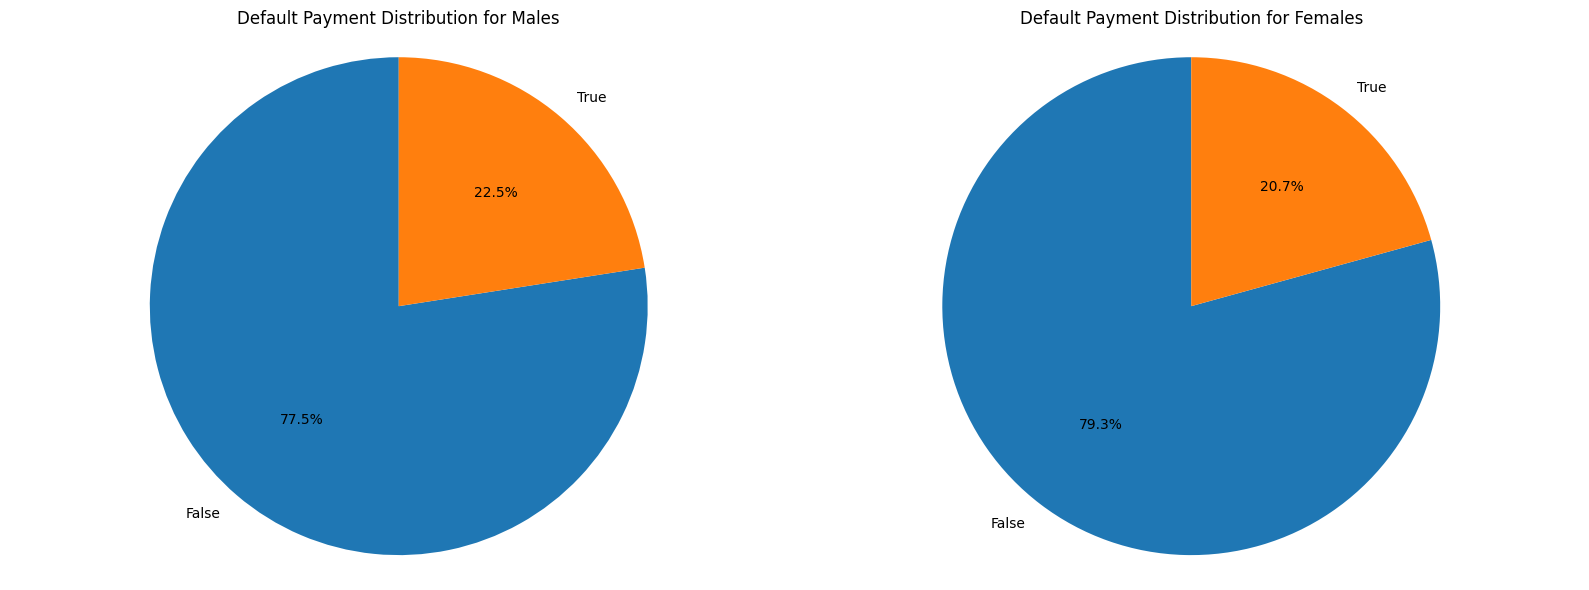

In [23]:
# Calculate the number of defaults per gender
default_by_gender = df_eda.groupby('sex')['default_payment'].value_counts().unstack()

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart for Males (Gender 1)
male_defaults = default_by_gender.loc[1]  # Get data for males
axes[0].pie(male_defaults, labels=['False', 'True'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Default Payment Distribution for Males')
axes[0].axis('equal')  # Ensure the pie chart is circular

# Pie chart for Females (Gender 2)
female_defaults = default_by_gender.loc[2]  # Get data for females
axes[1].pie(female_defaults, labels=['False', 'True'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Default Payment Distribution for Females')
axes[1].axis('equal')  # Ensure the pie chart is circular

# Display both pie charts together
plt.tight_layout()
plt.show()

- Jika dilihat dari perbadingan tiap gender, nasabah laki-laki lebih besar mengalami gagal bayar dibanding nasabah perempuan walaupun dengan selisih yang tipis (±2%)

### 7.1.2 Distribution of Default Payment by Education Level

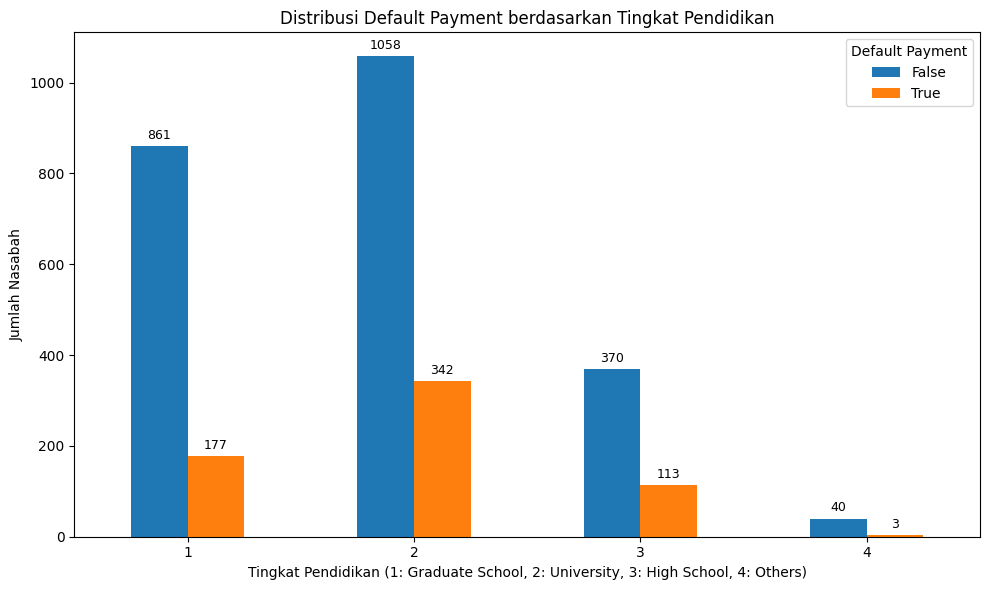

In [24]:
# Hitung jumlah default per tingkat pendidikan
default_by_education = df_eda.groupby('education_level')['default_payment'].value_counts().unstack()

# Plot jumlah default
ax = default_by_education.plot(kind='bar', figsize=(10, 6))

plt.title('Distribusi Default Payment berdasarkan Tingkat Pendidikan')
plt.xlabel('Tingkat Pendidikan (1: Graduate School, 2: University, 3: High School, 4: Others)')
plt.ylabel('Jumlah Nasabah')
plt.xticks(rotation=0)
plt.legend(title='Default Payment', labels=['False', 'True'])
plt.tight_layout()

# Tambahkan label jumlah di atas setiap bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

plt.show()


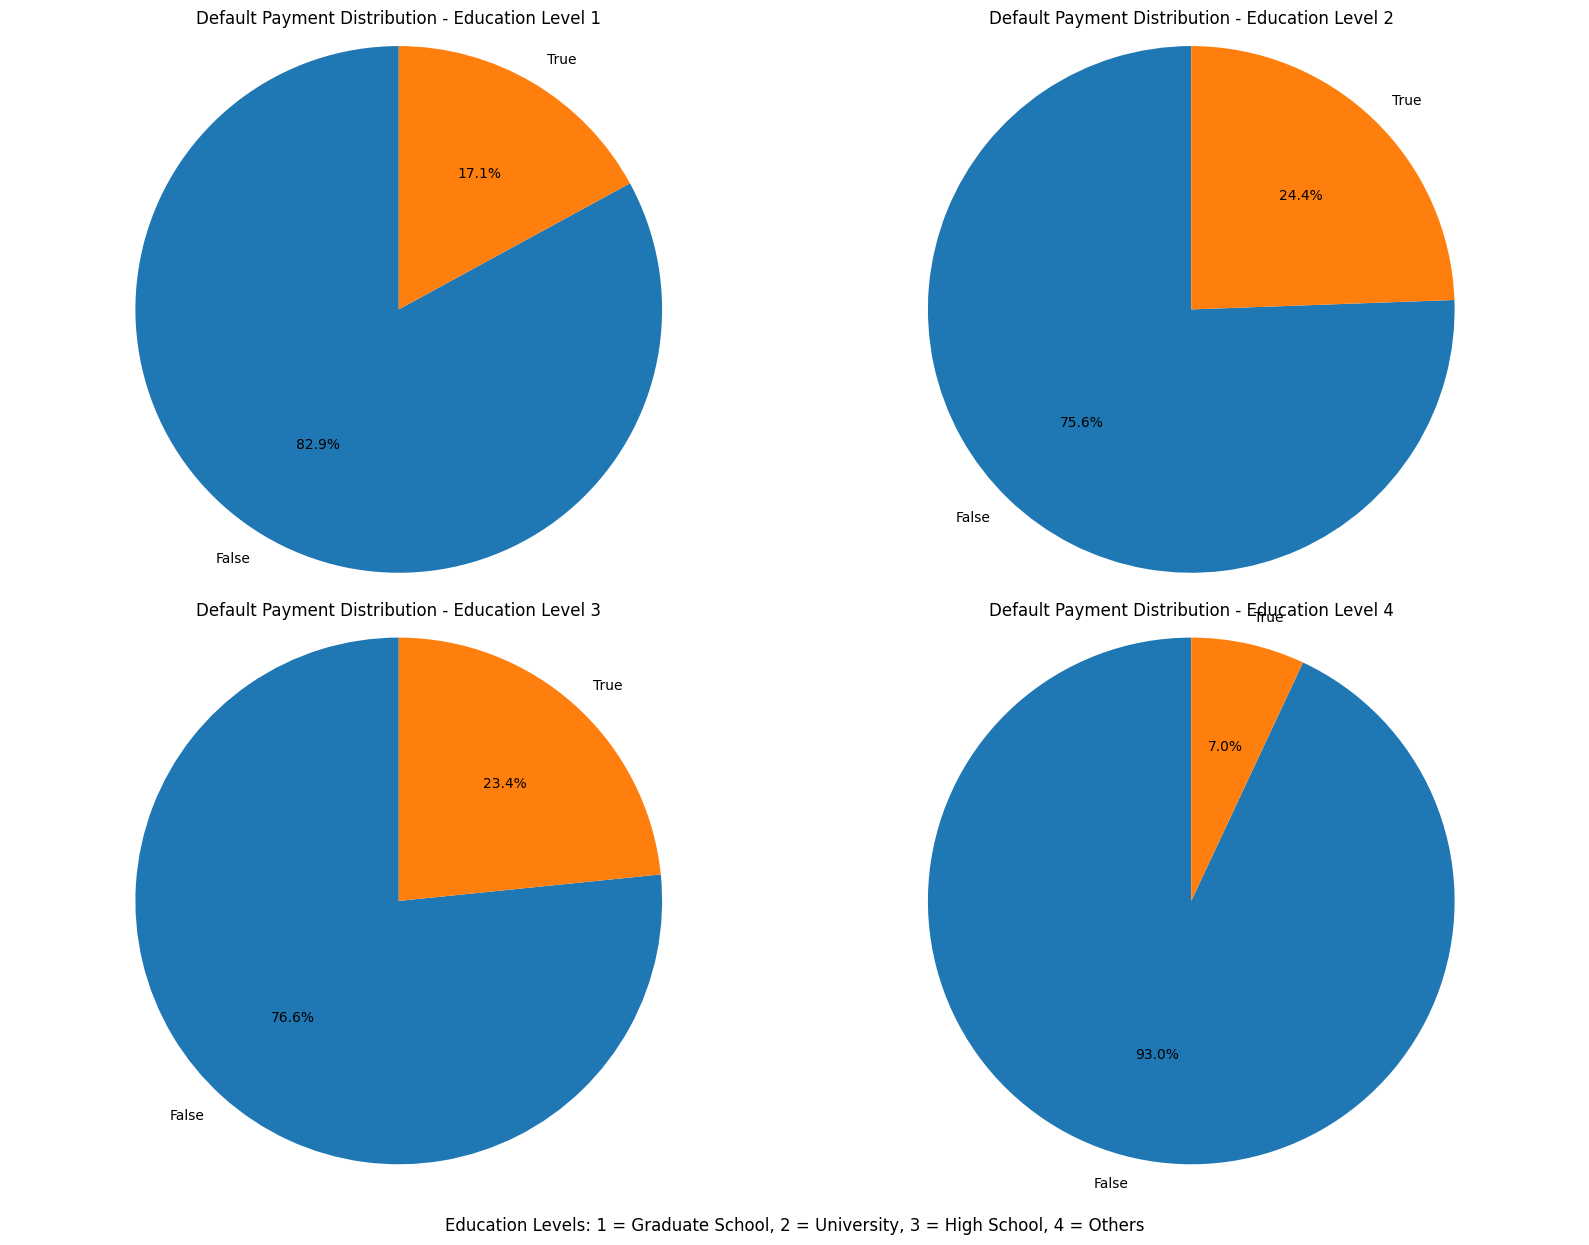

In [25]:
# Calculate the number of defaults per education level
default_by_education = df_eda.groupby('education_level')['default_payment'].value_counts().unstack()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pie chart for each education level
education_levels = [1, 2, 3, 4]
for i, education_level in enumerate(education_levels):
    row = i // 2
    col = i % 2
    education_defaults = default_by_education.loc[education_level]
    axes[row, col].pie(education_defaults, labels=['False', 'True'], autopct='%1.1f%%', startangle=90)
    axes[row, col].set_title(f'Default Payment Distribution - Education Level {education_level}')
    axes[row, col].axis('equal')

# Layout adjustment
plt.tight_layout()

# Add a caption below
fig.text(0.5, -0.03, 'Education Levels: 1 = Graduate School, 2 = University, 3 = High School, 4 = Others',
         ha='center', fontsize=12)

plt.show()

- Nasabah dengan tingkat pendidikan 'University' merupakan pengguna kartu kredit terbanyak, juga yang mengalami gagal bayar paling banyak dilihat dari jumlah dan presentasenya

### 7.1.3 Distribution of Default Payment by Marital Status

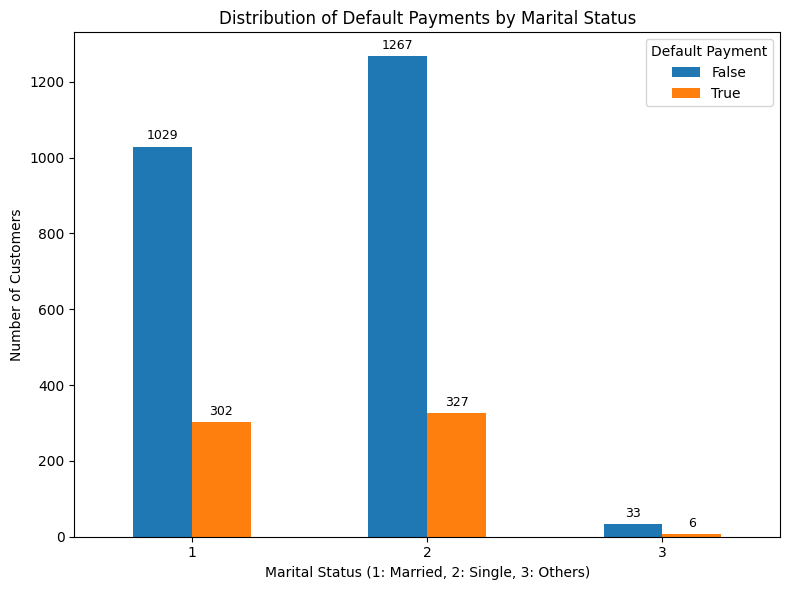

In [26]:
# Calculate the number of default payments per marital status
default_by_marital_status = df_eda.groupby('marital_status')['default_payment'].value_counts().unstack()

# Plot the number of default payments
ax = default_by_marital_status.plot(kind='bar', figsize=(8, 6))

plt.title('Distribution of Default Payments by Marital Status')
plt.xlabel('Marital Status (1: Married, 2: Single, 3: Others)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.legend(title='Default Payment', labels=['False', 'True'])
plt.tight_layout()

# Add count labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

plt.show()

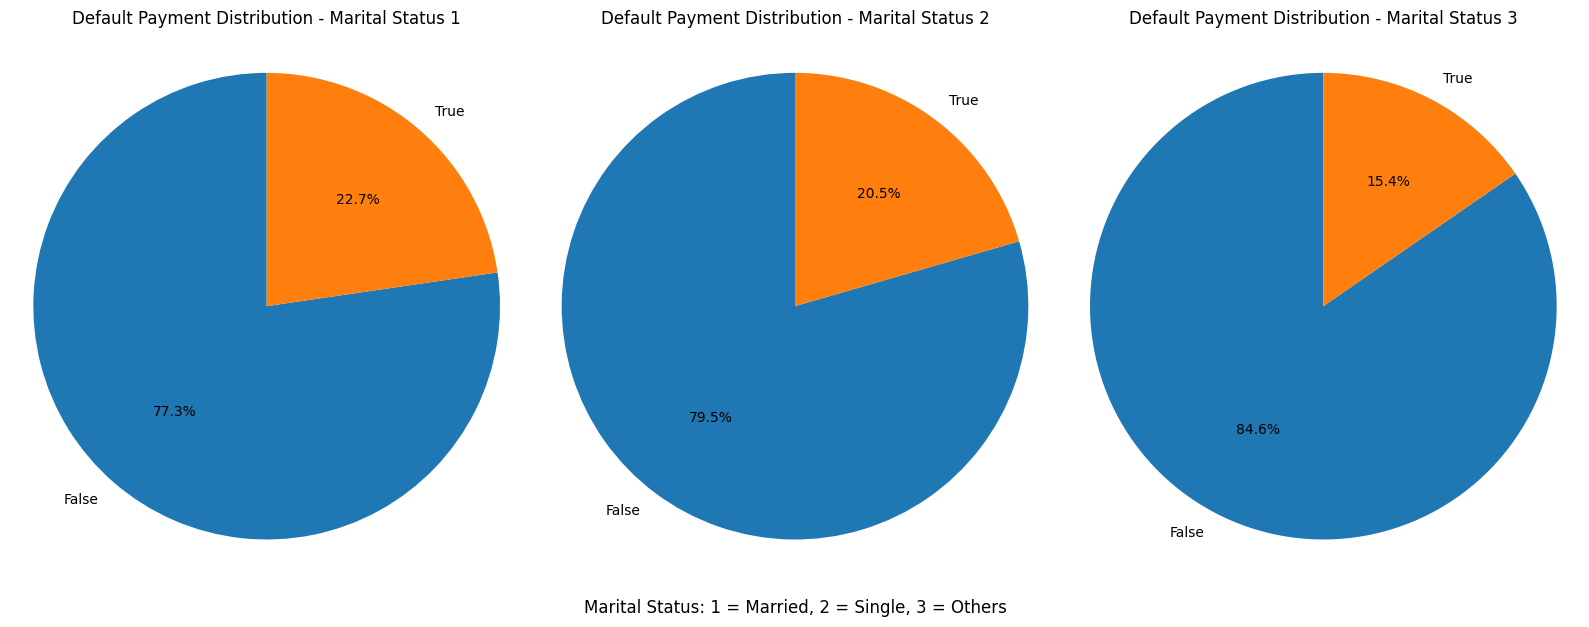

In [27]:
# Calculate the number of defaults per marital status
default_by_marital = df_eda.groupby('marital_status')['default_payment'].value_counts().unstack()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Pie chart for each marital status
marital_statuses = [1, 2, 3]
for i, marital_status in enumerate(marital_statuses):
    marital_defaults = default_by_marital.loc[marital_status]
    axes[i].pie(marital_defaults, labels=['False', 'True'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Default Payment Distribution - Marital Status {marital_status}')
    axes[i].axis('equal')

# Layout adjustment
plt.tight_layout()

# Add a caption below
fig.text(0.5, -0.03, 'Marital Status: 1 = Married, 2 = Single, 3 = Others',
         ha='center', fontsize=12)

plt.show()

- Nasabah yang belum menikah ('Single') jumlahnya paling banyak, namun persentasenya bukan yang paling besar

- Nasabah yang sudah menikah ('Married') merupakan nasabah yang secara persentase lebih besar dibandingkan yang belum menikah dan others

### 7.1.4 Distribution of Default Payment by Age

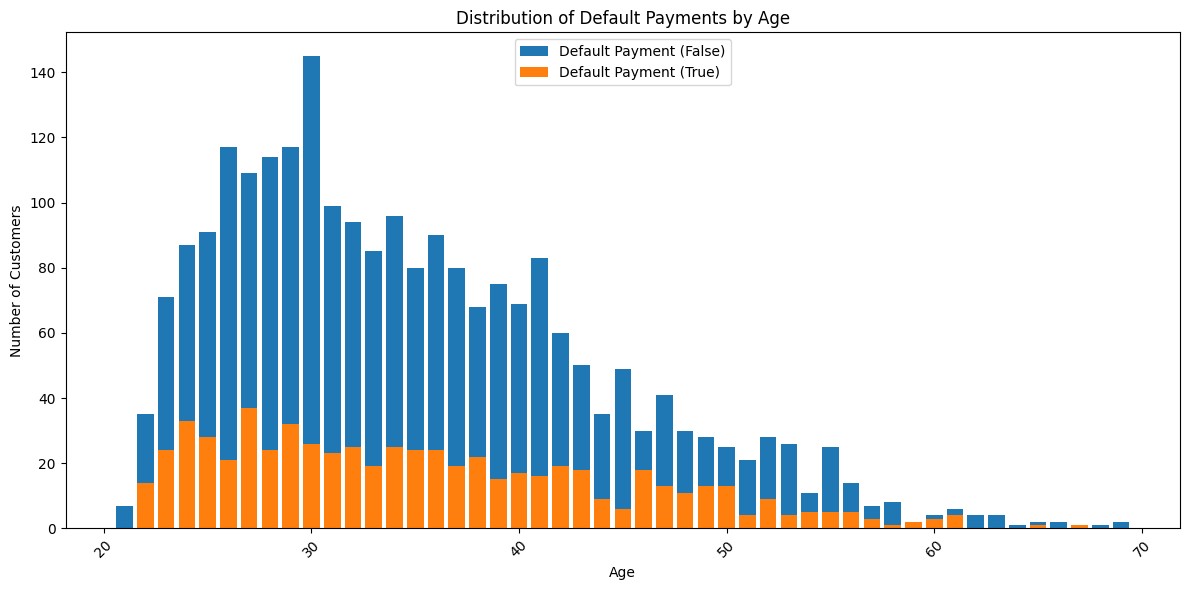

In [28]:
# Calculate the number of default payments per age
default_by_age = df_eda.groupby('age')['default_payment'].value_counts().unstack()

# Plot the number of default payments
plt.figure(figsize=(12, 6))

# Plot bars for 'False' (no default) first
plt.bar(default_by_age.index, default_by_age[False], label='Default Payment (False)')

# Plot bars for 'True' (default) starting from the base (bottom=0)
plt.bar(default_by_age.index, default_by_age[True], bottom=0, label='Default Payment (True)')


plt.title('Distribution of Default Payments by Age')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

- Jika dilihat dari usia, nasabah pengguna kartu kredit kebanyakan berada di rentang usia 23-42 tahun, dengan usia 30 yang paling banyak penggunanya. Namun, jika dilihat tingkat gagal bayarnya dari range usia tersebut terlihat tidak berbeda jauh banyaknya

## 7.2 Distribution of Limit Balance

### 7.2.1 Central Tendency of Limit Balance

In [29]:
# Calculate mean, median, and mode for 'limit_balance' where 'default_payment' is True
default_true_df = df_eda[df_eda['default_payment'] == True]

# Calculate the mean of 'limit_balance' for the filtered DataFrame
limit_balance_mean = np.mean(default_true_df['limit_balance'])

# Calculate the median of 'limit_balance' for the filtered DataFrame
limit_balance_median = np.median(default_true_df['limit_balance'])

# Calculate the mode of 'limit_balance' for the filtered DataFrame
# .mode() returns a Series, so [0] is used to get the first mode in case of multiple modes
limit_balance_mode = default_true_df['limit_balance'].mode()[0]

# Print the calculated statistics
print(f"Mean of limit_balance for default_payment   = {limit_balance_mean}")
print(f"Median of limit_balance for default_payment = {limit_balance_median}")
print(f"Mode of limit_balance for default_payment   = {limit_balance_mode}")

Mean of limit_balance for default_payment   = 124598.4251968504
Median of limit_balance for default_payment = 90000.0
Mode of limit_balance for default_payment   = 50000.0


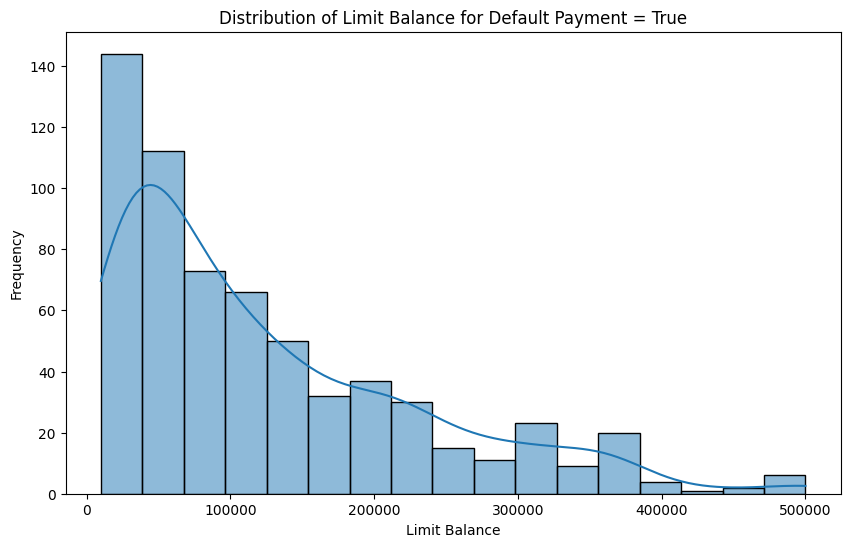

Skewness of limit_balance for default_payment = 1.1933392815508048


In [30]:
# Filter data where default_payment is True
default_true_df = df_eda[df_eda['default_payment'] == True]

# Visualize the distribution of limit_balance for default_payment = True
plt.figure(figsize=(10, 6))
sns.histplot(default_true_df['limit_balance'], kde=True)
plt.title('Distribution of Limit Balance for Default Payment = True')
plt.xlabel('Limit Balance')
plt.ylabel('Frequency')
plt.show()

# Check the skewness of limit_balance for default_payment = True
skewness = default_true_df['limit_balance'].skew()
print(f"Skewness of limit_balance for default_payment = {skewness}")

- Rata-rata limit balance nasabah yang mengalami gagal bayar yaitu `NT$ 124.598`

- Nasabah kartu kredit yang gagal bayar dengan limit balance tinggi tidak banyak (hanya beberapa) dibandingkan nasabah kartu kredit yang gagal bayar dengan limit balance yang lebih kecil. Artinya limit_balance dapat mempengaruhi kemugkinan gagal bayar nasabah pada periode berikutnya

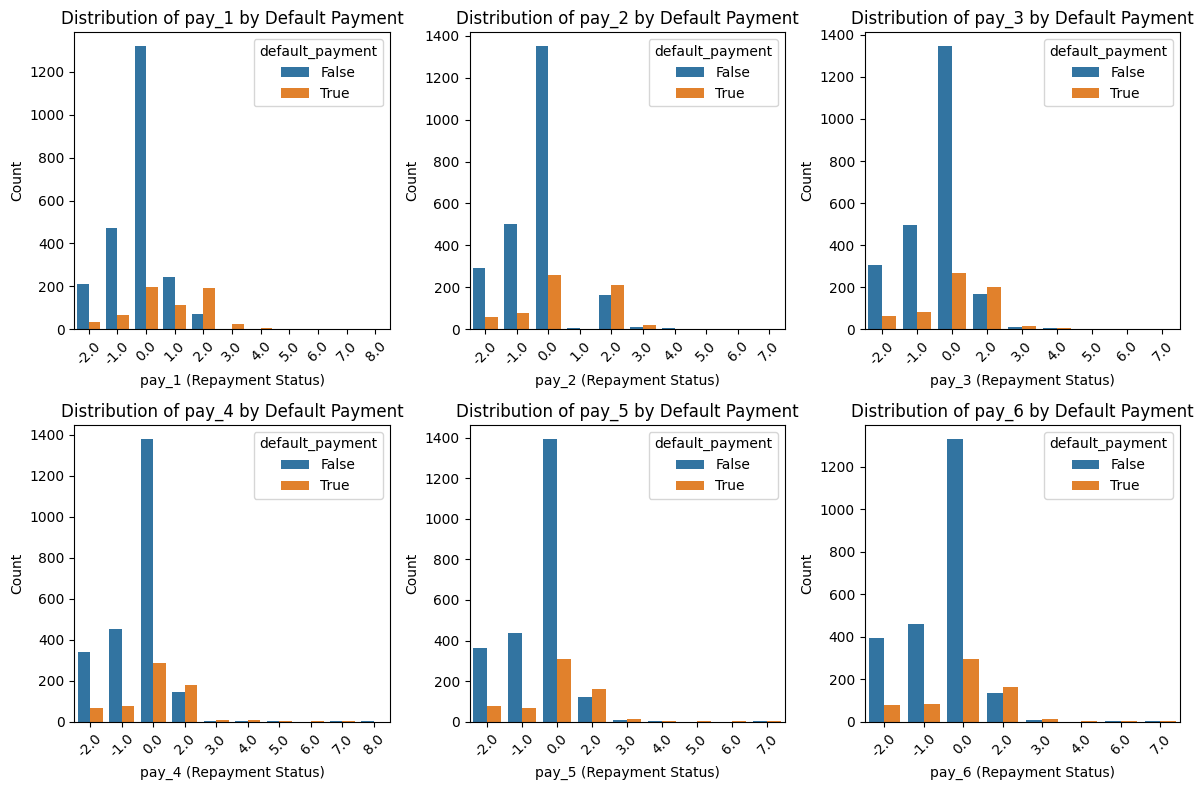

In [31]:
# Visualizing the relationship between 'pay_n' and 'default_payment'
pay_cols = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

plt.figure(figsize=(12, 8))
for i, col in enumerate(pay_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='default_payment', data=df_eda)
    plt.title(f'Distribution of {col} by Default Payment')
    plt.xlabel(f'{col} (Repayment Status)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


- Terlihat adanya sejumlah kecil nasabah yang tercatat gagal bayar (default_payment = True, batang oranye) meskipun riwayat pembayarannya menunjukkan -2, -1 dam 0 (pembayaran tepat waktu).
---



 Kenapa hal itu bisa terjadi?

 Meskipun secara logika dan berdasarkan tren umum yang terlihat di grafik, riwayat pembayaran yang baik seharusnya menurunkan risiko gagal bayar, ada beberapa kemungkinan mengapa hal ini bisa terjadi:

  1. Keterlambatan Pembayaran Setelah Periode Pengamatan: Kolom `pay_1` hingga `pay_6` merekam status pembayaran untuk enam bulan terakhir sebelum tanggal pernyataan. Bisa jadi nasabah-nasabah ini memiliki riwayat pembayaran yang baik selama periode tersebut, namun mengalami kesulitan keuangan dan gagal bayar setelah periode pengamatan ini.

  2. Kapasitas Keuangan yang Berubah: Kehilangan pekerjaan, penurunan pendapatan, atau peningkatan pengeluaran setelah periode pengamatan riwayat pembayaran.

  3. Jumlah Kredit yang Terlalu Tinggi: Meskipun membayar tepat waktu di masa lalu, total beban utang nasabah mungkin menjadi terlalu besar.



## 7.2 Copy DataFrame for FE

In [32]:
# Create a copy of the DataFrame df_eda to df_fe
df_fe = df_eda.copy()

# Display the first five rows of the DataFrame df_fe
df_fe.head()

,limit_balance,sex,education_level,marital_status,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment
0,80000.0,1,4,1,54.0,0.0,0.0,0.0,0.0,0.0,0.0,61454.0,61808.0,62290.0,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,True
1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,0.0,0.0,49221.0,49599.0,50942.0,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,False
2,20000.0,2,4,2,22.0,0.0,0.0,0.0,0.0,0.0,0.0,19568.0,19420.0,15535.0,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,True
3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,0.0,0.0,18457.0,22815.0,27086.0,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,False
4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,0.0,0.0,159919.0,68686.0,161192.0,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,False


# VIII. FEATURE ENGINEERING

## 8.1 Feature Selection

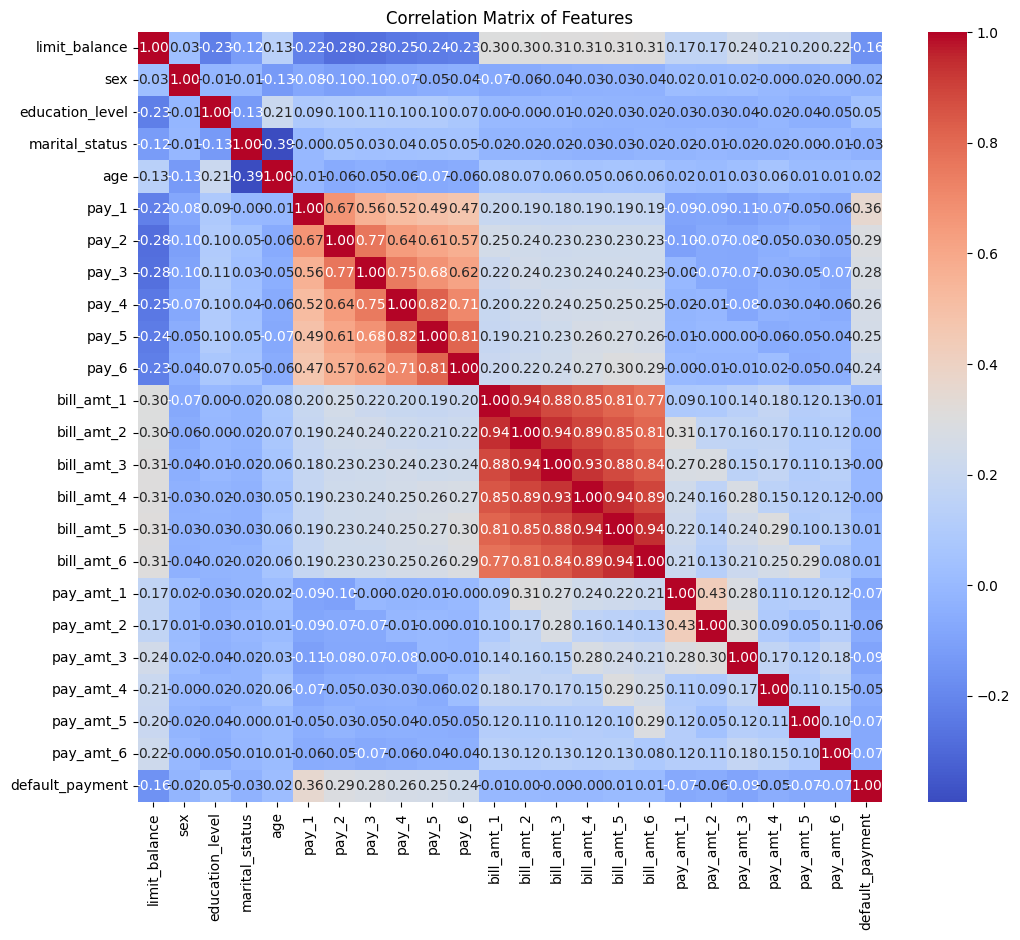

In [33]:
# Calculates and visualizes the correlation matrix of all numerical features in the df_eda DataFrame using a heatmap.
plt.figure(figsize=(12, 10))
correlation_matrix = df_eda.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

Setelah melakukan cek korelasi menggungakan heat map, dapat terlihat bahwa korelasi tiap kolom terhadap target ('default_payment') memang kecil. namun, perlu diingat bahwa:

  1. Korelasi Bukan Segalanya: Meskipun korelasi membantu dalam mengidentifikasi hubungan linear antar variabel, model machine learning yang kompleks dapat menangkap hubungan non-linear dan dan interaksi antar fitur yang tidak terlihat hanya dari matriks korelasi.

  2.  Domain Knowledge: Pemahaman Anda tentang bisnis dan data (misalnya, bagaimana proses persetujuan kredit bekerja) juga sangat penting dalam memilih fitur.

  3. Evaluasi Model: Kunci utama dalam memilih fitur yang baik adalah dengan membangun model dan mengevaluasi performanya menggunakan metrik yang sesuai.

Oleh karena itu, kolom-kolom yang akan digunakan yaitu:

  - Kolom Target: `default_payment_next_month`
  
  - Kolom Numeric: `limit_balance`, `age`,`pay_1`, `pay_2`, `pay_3`, `pay_4`, `pay_5`, `pay_6`, `bill_amt_1`, `bill_amt_2`, `bill_amt_3`, `bill_amt_4`, `bill_amt_5`, `bill_amt_6`, `pay_amt_1`, `pay_amt_2`, `pay_amt_3`, `pay_amt_4`, `pay_amt_5`, `pay_amt_6`

  - Kolom Categorical Nominal: `sex`,`education_level`, `marital_status`

## 8.2 Split Features and Target

In [34]:
# Define X (features) and y (target variable)
X = df_fe.drop('default_payment', axis=1)
y = df_fe['default_payment']

## 8.3 Split Train Set and Test Set

In [35]:
# Split Train and Test Set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3, random_state=23)

# Number of samples in the training set and test set
print('Train Size:', X_train.shape)
print('Test Size:', X_test.shape)

Train Size: (2074, 23)
Test Size: (890, 23)


## Split Numerical and Categorical Column

In [36]:
# Define numerical and categorical columns
num_col = ['limit_balance', 'bill_amt_1' , 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5','pay_amt_6'] # List of columns identified as numerical features.
cat_col = ['sex', 'education_level', 'marital_status', 'age','pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'] # List of columns identified as categorical features.

# Define nominal and ordinal categorical columns
num_col_n = ['limit_balance', 'bill_amt_1' , 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5','pay_amt_6']
cat_col_n = ['sex', 'education_level', 'marital_status', 'age']
cat_col_o = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

In [37]:
# Split between numerical and categorical columns in Train and Test set

# For the training set (X_train):
X_train_num_n = X_train[num_col_n] # Selects numerical columns (as defined in num_col_n) from the training features.
X_train_cat = X_train[cat_col]     # Selects all categorical columns (as defined in cat_col) from the training features.
X_train_cat_n = X_train[cat_col_n] # Selects nominal categorical columns (as defined in cat_col_n) from the training features.
X_train_cat_o = X_train[cat_col_o] # Selects ordinal categorical columns (as defined in cat_col_o) from the training features.

# For the test set (X_test):
X_test_num_n = X_test[num_col_n]   # Selects numerical columns from the test features.
X_test_cat = X_test[cat_col]       # Selects all categorical columns from the test features.
X_test_cat_n = X_test[cat_col_n]   # Selects nominal categorical columns from the test features.
X_test_cat_o = X_test[cat_col_o]   # Selects ordinal categorical columns from the test features.

## 8.4 Handling Outlier

In [38]:
# Let's check whether a distribution is normal or not
print('Distribution of column `limit_balance`  : ', X_train['limit_balance'].skew())

Distribution of column `limit_balance`  :  0.9641574853281119


- Terlihat bahwa kolom `limit_balance` memiliki distribusi yang tidak tidak normal (Skewed Distribution)

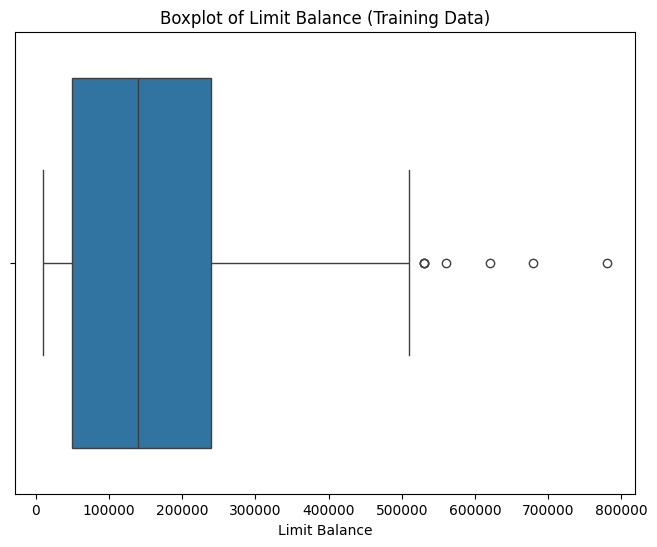

In [39]:
# Visualize the distribution of `limit_balance` using a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=X_train['limit_balance'])
plt.title('Boxplot of Limit Balance (Training Data)')
plt.xlabel('Limit Balance')
plt.show()

- setelah dilakukan pengecekan, terlihat outlier pada visualisasi boxplot

### 8.4.1 Outlier in X_train_num_n (`limit_balance`)

In [40]:
# Calculate quartiles
Q1 = X_train_num_n['limit_balance'].quantile(0.25) # Calculates the first quartile (25th percentile) of 'limit_balance'.
Q3 = X_train_num_n['limit_balance'].quantile(0.75) # Calculates the third quartile (75th percentile) of 'limit_balance'.
IQR = Q3 - Q1 # Calculates the Interquartile Range (IQR), which is the range between Q1 and Q3.

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR # Defines the lower boundary for outlier detection (1.5 * IQR below Q1).
upper_bound = Q3 + 1.5 * IQR # Defines the upper boundary for outlier detection (1.5 * IQR above Q3).

# Identify outliers
# Filters the DataFrame to find rows where 'limit_balance' is either below the lower bound or above the upper bound.
outliers = X_train_num_n[(X_train_num_n['limit_balance'] < lower_bound) | (X_train_num_n['limit_balance'] > upper_bound)]

# Calculate the percentage of outliers
outlier_percentage = (len(outliers) / len(X_train_num_n)) * 100 # Calculates the percentage of identified outliers relative to the total number of samples.

print(f"Percentage of outliers in 'limit_balance': {outlier_percentage:.2f}%") # Prints the calculated percentage, formatted to two decimal places.

Percentage of outliers in 'limit_balance': 0.34%


- persentasi outlier pada data latih hanya sebesar 0.34%, karena sangat kecil maka diputuskan untuk tidak dilakukan handling pada outlier tersebut karena bisa jadi data nasabah yang termasuk outlier itu memang data real

### 8.4.1 Outlier in X_test_num_n (`limit_balance`)

In [41]:
# Calculate quartiles
Q1 = X_test_num_n['limit_balance'].quantile(0.25) # Calculates the first quartile (25th percentile) of 'limit_balance' in the test set.
Q3 = X_test_num_n['limit_balance'].quantile(0.75) # Calculates the third quartile (75th percentile) of 'limit_balance' in the test set.
IQR = Q3 - Q1 # Calculates the Interquartile Range (IQR) for the test set.

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR # Defines the lower boundary for outlier detection in the test set.
upper_bound = Q3 + 1.5 * IQR # Defines the upper boundary for outlier detection in the test set.

# Identify outliers
# Filters the test set to find rows where 'limit_balance' is either below the lower bound or above the upper bound.
outliers = X_test_num_n[(X_test_num_n['limit_balance'] < lower_bound) | (X_test_num_n['limit_balance'] > upper_bound)]

# Calculate the percentage of outliers
outlier_percentage = (len(outliers) / len(X_test_num_n)) * 100 # Calculates the percentage of identified outliers in the test set.

print(f"Percentage of outliers in 'limit_balance': {outlier_percentage:.2f}%") # Prints the calculated percentage, formatted to two decimal places.

Percentage of outliers in 'limit_balance': 0.56%


- Begitu juga pada data uji, tidak lebih dari 1%

- kesimpulan: Data pada `X_train_num_n` dan `X_test_num_n` akan dilanjutkan langsung ke pemodelan

## 8.5 Feature Scaling

- Data pada X_train_num_n merupakan numerik dan skew, maka akan menggunakan fitur MinMax Scaler pada X_train_num_n

In [42]:
# Assuming X_train_num contains the numerical features from X_train
scaler = MinMaxScaler() # Initializes the MinMaxScaler. This scaler transforms features by scaling each feature to a given range, typically between 0 and 1.

scaler.fit(X_train_num_n[['limit_balance']]) # Fits the scaler ONLY on the 'limit_balance' column of the training data. The scaler learns the min and max values from this data.

X_train_num_scaled = scaler.fit_transform(X_train_num_n[['limit_balance']]) # Transforms the 'limit_balance' column in the training data using the learned min/max values. fit_transform() is used here as it fits and then transforms.
X_test_num_scaled = scaler.transform(X_test_num_n[['limit_balance']]) # Transforms the 'limit_balance' column in the test data using the SAME min/max values learned from the training data. This is crucial to prevent data leakage from the test set.

## 8.6 Feature Encoding

### 8.6.1 Categorical Ordinal Column

In [43]:
# Create an OrdinalEncoder object
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) # Initializes OrdinalEncoder.

# Fit the encoder on the training data
encoder.fit(X_train_cat_o) # Fits the encoder ONLY on the ordinal categorical columns of the training data. It learns the unique categories and their order from this data.

# Transform both the training and testing data using the fitted encoder
X_train_cat_encoded = encoder.transform(X_train_cat_o) # Transforms the training data using the learned encoding.
X_test_cat_encoded = encoder.transform(X_test_cat_o)   # Transforms the test data using the SAME learned encoding. This is crucial to prevent data leakage from the test set.

### 8.6.2 Categorical Nominal Column

In [44]:
ohe = OneHotEncoder(handle_unknown='ignore') # Initializes the OneHotEncoder, which converts categorical variables into a one-hot numerical format. 'handle_unknown='ignore'' ensures that any new, unseen categories in the test set will be encoded as all zeros without raising an error.

ohe.fit(X_train_cat_n) # Fits the encoder to the nominal categorical columns in the training data (X_train_cat_n). This step makes the encoder learn all unique categories present in these columns.

X_train_cat_encoded_n = ohe.fit_transform(X_train_cat_n).toarray() # Transforms the training data using the learned encoding. .toarray() converts the output from a sparse matrix (memory-efficient) to a dense NumPy array, which is typically required by machine learning models.
X_test_cat_encoded_n = ohe.transform(X_test_cat_n).toarray() # Transforms the test data using the SAME encoder that was fitted on the training data. This is crucial for consistency and to prevent data leakage from the test set into the training process.

## 8.7 Concatenate Feature

In [45]:
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_encoded, X_train_cat_encoded_n], axis=1) # Concatenates the scaled numerical features, ordinal encoded categorical features, and one-hot encoded nominal categorical features for the training set into a single array.
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_encoded, X_test_cat_encoded_n], axis=1)   # Concatenates the corresponding processed features for the test set into a single array.

# IX. MODEL DEFINITION

## 9.1 Logistic Regression

- Logistic Regression cocok untuk kasus prediksi gagal bayar kartu kredit karena target variabelnya kategorikal dan model ini mudah diinterpretasi. Efisiensi dan kemampuannya sebagai baseline juga menjadi nilai tambah.

In [46]:
model_logreg = LogisticRegression() # Initializes a Logistic Regression model.

## 9.2 Support Vector Machine (SVM)

- SVM cocok untuk kasus ini karena kemampuannya menangani data berdimensi tinggi dan kompleksitas hubungan antar fitur. SVM juga efektif dalam menemukan hyperplane optimal untuk pemisahan kelas yang baik, sehingga berpotensi menghasilkan prediksi yang akurat dalam kasus gagal bayar. Kemampuannya menangani outlier juga menjadi nilai tambah.

In [47]:
svm = SVC() # Initializes a Support Vector Classifier (SVC) model.

## 9.3 K-Nearest Neighbors (KNN)

- KNN adalah algoritma yang sederhana dan mudah diimplementasikan. KNN bekerja dengan mengklasifikasikan data baru berdasarkan kedekatannya dengan data-data yang sudah ada. Dalam konteks gagal bayar, KNN akan melihat data nasabah lain yang mirip dan memprediksi apakah nasabah baru tersebut akan gagal bayar atau tidak. Meskipun sederhana, KNN bisa memberikan hasil yang cukup akurat, terutama jika data sudah di-preprocessing dengan baik

In [48]:
knn = KNeighborsClassifier() # Initializes a K-Nearest Neighbors Classifier model.

# X. MODEL TRAINING

## 10.1 Logistic Regression

In [49]:
model_logreg.fit(X_train_final, y_train) # Trains the Logistic Regression model using the preprocessed training features (X_train_final) and their corresponding true labels (y_train).

LogisticRegression()

## 10.2 Support Vector Machine (SVM)

In [50]:
svm.fit(X_train_final, y_train) # Trains the Support Vector Classifier (SVC) model using the preprocessed training features (X_train_final) and their corresponding true labels (y_train).

SVC()

## 10.3 K-Nearest Neighbors (KNN)

In [51]:
knn.fit(X_train_final, y_train) # Trains the K-Nearest Neighbors Classifier (KNN) model by "fitting" it to the preprocessed training features (X_train_final) and their corresponding true labels (y_train).

KNeighborsClassifier()

# XI. MODEL EVALUATION

## 11.1 Logistic Regression

In [52]:
# Generates predictions for the training set using the trained Logistic Regression model.
y_pred_train_logreg = model_logreg.predict(X_train_final)

# Generates predictions for the test set using the trained Logistic Regression model.
y_pred_test_logreg = model_logreg.predict(X_test_final)

In [53]:
# Prints the precision score for the Logistic Regression model on the training set.
print('Logistic Regression - Precision - Train Set : ',precision_score(y_train, y_pred_train_logreg))

# Prints the precision score for the Logistic Regression model on the test set.
print('Logistic Regression - Precision - Test Set  : ',precision_score(y_test, y_pred_test_logreg))

Logistic Regression - Precision - Train Set :  0.7613636363636364
Logistic Regression - Precision - Test Set  :  0.7083333333333334


## 11.2 Support Vector Machine (SVM)

In [54]:
# Generates predictions for the training set using the trained Support Vector Classifier (SVC) model.
y_pred_train_svm = svm.predict(X_train_final)

# Generates predictions for the test set using the trained Support Vector Classifier (SVC) model.
y_pred_test_svm = svm.predict(X_test_final)

In [55]:
# Prints the precision score for the SVM model on the training set.
print('SVM Model - Precision - Train Set : ',precision_score(y_train, y_pred_train_svm))

# Prints the precision score for the SVM model on the test set.
print('SVM Model - Precision - Test Set  : ',precision_score(y_test, y_pred_test_svm))

SVM Model - Precision - Train Set :  0.7479338842975206
SVM Model - Precision - Test Set  :  0.7155963302752294


---

## 11.3 K-Nearest Neighbors (KNN)

In [56]:
# Generates predictions for the training set using the trained K-Nearest Neighbors Classifier (KNN) model.
y_pred_train_knn = knn.predict(X_train_final)

# Generates predictions for the test set using the trained K-Nearest Neighbors Classifier (KNN) model.
y_pred_test_knn = knn.predict(X_test_final)

In [57]:
# Prints the precision score for the KNN model on the training set.
print('KNN Model - Precision - Train Set : ',precision_score(y_train, y_pred_train_knn))

# Prints the precision score for the KNN model on the test set.
print('KNN Model - Precision - Test Set  : ',precision_score(y_test, y_pred_test_knn))

KNN Model - Precision - Train Set :  0.7372262773722628
KNN Model - Precision - Test Set  :  0.6896551724137931


# XII. HYPERPARAMETER TUNING

## 12.1 Logistic Regression

In [58]:
# Define parameters to be tested
param_grid_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'random_state': [23]
}

# Create Logistic Regression model
logreg_model = LogisticRegression()

# Perform Grid Search with cross-validation (5 fold) and precision optimization
grid_search_logreg = GridSearchCV(logreg_model, param_grid_logreg, cv=5, scoring='precision', n_jobs=-1)

# Train Grid Search on training data
grid_search_logreg.fit(X_train_final, y_train)

# Display best parameters and best score
print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)
print("Best cross-validation precision score:", grid_search_logreg.best_score_)

Best parameters for Logistic Regression: {'C': 0.01, 'penalty': 'l2', 'random_state': 23}
Best cross-validation precision score: 0.766468253968254


## 12.2 Support Vector Machine (SVM)

In [59]:
# Define parameters to be tested
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'random_state': [23]
}

# Create Support Vector Classifier (SVC) model
svm_model = SVC()

# Perform Grid Search with cross-validation (5 fold) and optimize for precision
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='precision', n_jobs=-1)

# Train Grid Search on training data
grid_search_svm.fit(X_train_final, y_train)

# Display best parameters and best score
print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best cross-validation precision score:", grid_search_svm.best_score_)

Best parameters for SVM: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 23}
Best cross-validation precision score: 0.7806309222253495


## 12.3 K-Nearest Neighbors (KNN)

In [60]:
# Define parameters to be tested
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'], # Optional
    'metric': ['euclidean', 'manhattan'] # Optional
}

# Create K-Nearest Neighbors (KNN) model
knn_model = KNeighborsClassifier()

# Perform Grid Search with cross-validation (5 fold) and optimize for precision
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='precision', n_jobs=-1)

# Train Grid Search on training data
grid_search_knn.fit(X_train_final, y_train)

# Display best parameters and best score
print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best cross-validation precision score:", grid_search_knn.best_score_)

Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}
Best cross-validation precision score: 0.6810824336595702


---

## 12.4 Best Model

In [61]:
# Get the best model from each Grid Search
best_logreg_model = grid_search_logreg.best_estimator_
best_svm_model = grid_search_svm.best_estimator_
best_knn_model = grid_search_knn.best_estimator_

# Predict on test data using the best models
y_pred_test_logreg_tuned = best_logreg_model.predict(X_test_final)
y_pred_test_svm_tuned = best_svm_model.predict(X_test_final)
y_pred_test_knn_tuned = best_knn_model.predict(X_test_final)

# Calculate Precision before Tuning on Test Data
precision_test_logreg_before = precision_score(y_test, y_pred_test_logreg)
precision_test_svm_before = precision_score(y_test, y_pred_test_svm)
precision_test_knn_before = precision_score(y_test, y_pred_test_knn)

# Evaluate Precision on test data after tuning
precision_test_logreg_tuned = precision_score(y_test, y_pred_test_logreg_tuned)
precision_test_svm_tuned = precision_score(y_test, y_pred_test_svm_tuned)
precision_test_knn_tuned = precision_score(y_test, y_pred_test_knn_tuned)

# Print comparison results
print("Precision on Test Data Before Tuning:")
print("Logistic Regression (Before Tuning):", precision_test_logreg_before)
print("SVM (Before Tuning):", precision_test_svm_before)
print("KNN (Before Tuning):", precision_test_knn_before)

print("\nPrecision on Test Data After Tuning:")
print("Logistic Regression (Tuned):", precision_test_logreg_tuned)
print("SVM (Tuned):", precision_test_svm_tuned)
print("KNN (Tuned):", precision_test_knn_tuned)

Precision on Test Data Before Tuning:
Logistic Regression (Before Tuning): 0.7083333333333334
SVM (Before Tuning): 0.7155963302752294
KNN (Before Tuning): 0.6896551724137931

Precision on Test Data After Tuning:
Logistic Regression (Tuned): 0.7843137254901961
SVM (Tuned): 0.71875
KNN (Tuned): 0.7578947368421053


---

# XIII. MODEL SAVING

In [62]:
# # Save the numerical column list
# with open('list_num_cols_n.txt', 'w') as file:
#   json.dump(num_col_n, file)

# # Save the categorical nominal column list
# with open('list_cat_cols_n.txt', 'w') as file:
#   json.dump(cat_col_n, file)

# # Save the categorical ordinal column list
# with open('list_cat_cols_o.txt', 'w') as file:
#   json.dump(cat_col_o, file)

# # Save the MinMaxScaler object
# with open('scaler_minmax.pkl', 'wb') as file:
#   pickle.dump(scaler, file)

# # Save the OrdinalEncoder object
# with open('encoder_ordinal.pkl', 'wb') as file:
#   pickle.dump(encoder, file)

# # Save the OneHotEncoder object
# with open('encoder_onehot.pkl', 'wb') as file:
#   pickle.dump(ohe, file)

# # Save the best Logistic Regression model
# with open('model_logreg_tuned.pkl', 'wb') as file:
#   pickle.dump(best_logreg_model, file)

# # Save the best SVM model
# with open('model_svm_tuned.pkl', 'wb') as file:
#   pickle.dump(best_svm_model, file)

# # Save the best KNN model
# with open('model_knn_tuned.pkl', 'wb') as file:
#   pickle.dump(best_knn_model, file)

# print("Models and lists saved successfully!")


# XIV. MODEL INFERENCE

- Model Inference dibuat pada notebook yang terpisah:

`Credit Card Anlaysis of Default Payment (Model Inference).ipynb`

# XV. CONCLUSION

Setelah dilakukan analisis lebih dalam terhadap data dan model yang telah dibuat, didapatkan model yang terbaik adalah Logistik Regression dengan tingkat akurasi 0.78 atau 78%. Artinya model mampu memprediksi nasabah yang gagal bayar sebanyak 78 orang dari 100 orang yang ada.

note:
- Skor hasil uji dapat lebih baik (bisa ditingkatkan) lagi dengan mencoba menggunakan parameter lain, maupun pemilihan fitur yang disesuaikan dengan kebutuhan.